# Test of first, basic model on full dataset

In [21]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
import h5py

import tensorflow as tf
# Set logging level to avoid unnecessary messages
tf.get_logger().setLevel('ERROR')
# Set autograph verbosity to avoid unnecessary messages
tf.autograph.set_verbosity(0)

import keras
import tensorflow_io as tfio
import tensorflow_probability as tfp
import tensorflow_extra as tfe
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio

from pathlib import Path
import sys
import os
import time
import gc
import warnings
# suppress all warnings
warnings.filterwarnings("ignore")


#tf.config.set_visible_devices([], 'GPU')


from tensorflow.keras.mixed_precision import Policy, set_global_policy

policy = Policy('mixed_float16')
set_global_policy(policy)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            #tf.config.experimental.set_virtual_device_configuration(
            #    gpu,
            #    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=16000)])
    except RuntimeError as e:
        print(e)

In [22]:
import wandb

### Load data

In [23]:
df = pd.read_csv("../../data/dataset_train.csv")
len(df)

13875

## Configurations

In [24]:
class cfg:
    # random seed
    seed = 42

    # audio clip settings
    sr = 22050
    duration = 15 # the duration of the clips
    
    n_samples = duration*sr
    
    hop_length = 2048 # "stepsize" of the fft for the melspectrograms
    nfft = 4096 # windowsize of the fft for the melspectrograms
    n_mels = 128 # number of mel frequency bins
    fmax = sr/2 # maximum frequency in the melspectrograms
    input_dim = (n_mels, int(duration*sr//hop_length + 1))
    
    # training settings, mild sweep 8
    batch_size = 32
    n_epochs = 50
    optimizer = "adam"
    activation = "leaky_relu"
    n_filters = 64
    tf_mask = True
    batch_norm = False
    dropout1 = 0.2
    dropout2 = 0.4
    duration = 15
    
    # class labels/names
    n_classes = len(np.unique(df.en))

# set random seed in keras
tf.keras.utils.set_random_seed(cfg.seed)

### Up- and downsample df

In [25]:
def upsample_data(df, thr=200):
    # get the class distribution
    class_dist = df['en'].value_counts()

    # identify the classes that have less than the threshold number of samples
    down_classes = class_dist[class_dist < thr].index.tolist()

    # create an empty list to store the upsampled dataframes
    up_dfs = []

    # loop through the undersampled classes and upsample them
    for c in down_classes:
        # get the dataframe for the current class
        class_df = df.query("en==@c")
        # find number of samples to add
        num_up = thr - class_df.shape[0]
        # upsample the dataframe
        class_df = class_df.sample(n=num_up, replace=True, random_state=cfg.seed)
        # append the upsampled dataframe to the list
        up_dfs.append(class_df)

    # concatenate the upsampled dataframes and the original dataframe
    up_df = pd.concat([df] + up_dfs, axis=0, ignore_index=True)
    
    return up_df

def downsample_data(df, thr=400):
    # get the class distribution
    class_dist = df['en'].value_counts()
    
    # identify the classes that have less than the threshold number of samples
    up_classes = class_dist[class_dist > thr].index.tolist()

    # create an empty list to store the upsampled dataframes
    down_dfs = []

    # loop through the undersampled classes and upsample them
    for c in up_classes:
        # get the dataframe for the current class
        class_df = df.query("en==@c")
        # Remove that class data
        df = df.query("en!=@c")
        # upsample the dataframe
        class_df = class_df.sample(n=thr, replace=False, random_state=cfg.seed)
        # append the upsampled dataframe to the list
        down_dfs.append(class_df)

    # concatenate the upsampled dataframes and the original dataframe
    down_df = pd.concat([df] + down_dfs, axis=0, ignore_index=True)
    
    return down_df

## Train- validation split

In [26]:
df.fullfilename = "../" + df.fullfilename

In [27]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df, test_size=0.2, random_state=42)
df_val.reset_index(drop=True, inplace = True)
df_train = upsample_data(df_train, thr = max(df_train.groupby("label")["label"].count()))

In [28]:
len(df_train)

15962

## Functions, data generator etc.

In [29]:
# Generates random integer # from https://www.kaggle.com/code/wengsilu/birdclef24pretraining
def random_int(shape=[], minval=0, maxval=1):
    return tf.random.uniform(shape=shape, minval=minval, maxval=maxval, dtype=tf.int32)

# Generats random float
def random_float(shape=[], minval=0.0, maxval=1.0):
    rnd = tf.random.uniform(shape=shape, minval=minval, maxval=maxval, dtype=tf.float32)
    return rnd

def pad_spectrogram(spec, shape = cfg.input_dim, random = False):
    _ = np.zeros(shape)
    if random:
        rdm = random_int(maxval=shape[1]-spec.shape[1])
        _[:,rdm: rdm + spec.shape[1]] = spec 
    else:
        _[:,:spec.shape[1]] = spec
    return _

def load_spectrogram_slice(hdf5_path, name, start_row = 0, end_row =None, start_col = 0, end_col = None):
    with h5py.File(hdf5_path, 'r') as f:
        spectrogram_slice = f[name][start_row:end_row, start_col:end_col]
    return spectrogram_slice

def load_random_spec_slice(df, ID):
    name = df.spectrogram.iloc[ID]
    hdf5_path = os.path.dirname(df.fullfilename.iloc[ID]) + "/spectrograms.h5"
    spec_length = df.length_spectrogram.iloc[ID]
    if spec_length > cfg.input_dim[1]:
        rdm = random_int(maxval= spec_length - cfg.input_dim[1])
        return load_spectrogram_slice(hdf5_path = hdf5_path, name = name, start_col = rdm, end_col = rdm + cfg.input_dim[1])
    elif spec_length < cfg.input_dim[1]:
        return pad_spectrogram(load_spectrogram_slice(hdf5_path = hdf5_path, name = name), shape = cfg.input_dim, random = True)
    return load_spectrogram_slice(hdf5_path = hdf5_path, name = name)

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dataframe,
                 batch_size=cfg.batch_size, 
                 dim=cfg.input_dim,
                 n_channels =  1,
                 n_classes=cfg.n_classes, 
                 shuffle=True
                ):
        'Initialization'
        self.dim = dim
        self.n_channels = n_channels
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.dataframe = dataframe
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        K.clear_session()
        gc.collect()
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
        # Generate data
        #print("Generating new data")
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = load_random_spec_slice(self.dataframe, ID).reshape(*self.dim, self.n_channels)
            # Store class
            y[i] = self.dataframe.label.iloc[ID]
        X = X.reshape(len(X), *self.dim, self.n_channels)
        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['accuracy'])
    plt.plot(network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
def predict_file(df, ID, model):
    name = df.spectrogram.iloc[ID]
    hdf5_path = os.path.dirname(df.fullfilename.iloc[ID]) + "/spectrograms.h5"
    spec_length = df.length_spectrogram.iloc[ID]
    spec = load_spectrogram_slice(hdf5_path, name)
    slices = []
    
    for i in range(spec_length//cfg.input_dim[1]):
        slices.append(spec[:,i*cfg.input_dim[1]:(i+1)*cfg.input_dim[1]])
    if spec_length%cfg.input_dim[1]/cfg.input_dim[1] > 5/cfg.duration:
        # consider last slice, only if it is longer than the shortest clips in the dataset 
        slices.append(pad_spectrogram(spec[:, (i+1)*cfg.input_dim[1]:None], random = True))
    
    preds = model.predict(np.expand_dims(np.array(slices), axis = -1))
    
    return np.mean(preds, axis = 0) # return mean prediction

## Initialize wandb

In [30]:
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint, WandbEvalCallback

run = wandb.init(
    # Set the project where this run will be logged
    project="CNN_Birdcall_classification",
    # Track hyperparameters and run metadata
    config={
        "batch_size": cfg.batch_size,
        "epochs": cfg.n_epochs,
        "n_classes": cfg.n_classes,
        "audio duration": cfg.duration,
        "comment": "L2 regularizer in first dense layer"
    },
)

In [31]:
wandb_metric = WandbMetricsLogger()

path = "../models/Model_1.keras"

#model_checkpoint = WandbModelCheckpoint(path, 
#                                        monitor = "val_accuracy", 
#                                        verbose = 1, 
#                                        save_best_only=True,
#                                        mode = "max"
#                                       )

In [32]:
from keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint

model_checkpoint = ModelCheckpoint(path, 
                             monitor = "val_accuracy", 
                             verbose = 1, 
                             save_best_only=True,
                             mode = "max"
                            )

early_stopping = EarlyStopping(
    monitor="val_accuracy",
    patience=6,
    verbose=0,
    mode="max",
    restore_best_weights=False,
    start_from_epoch=30,
)

log_file = "../models/Model_1_log.csv"

csv_log = CSVLogger(log_file, separator=",", append=False)

In [33]:
class ClearMemory(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print("Clearing Memory")
        gc.collect()
        K.clear_session()

In [34]:
callbacks = [model_checkpoint, csv_log, WandbMetricsLogger(), early_stopping, ClearMemory()]

## Build model

In [35]:
from tensorflow.keras.layers import Layer, Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Input, BatchNormalization

tfm_layer = tfe.layers.TimeFreqMask(freq_mask_prob=0.5,
                                  num_freq_masks=2,
                                  freq_mask_param=15,
                                  time_mask_prob=0.5,
                                  num_time_masks=3,
                                  time_mask_param=15,
                                  time_last=True,
                        )

zscore_layer = tfe.layers.ZScoreMinMax()

def build_model():
    inp = Input(shape=(*cfg.input_dim, 1))
    
    # Normalize
    x = zscore_layer(inp)
    x = tfm_layer(x)
    
    # Base model
    x = Conv2D(32, kernel_size=(3, 3), padding='valid', activation='selu')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding="valid")(x)
    x = Conv2D(64, kernel_size=(3, 3), padding='valid', activation='selu')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding="valid")(x)
    x = Dropout(0.4)(x)
    x = Flatten()(x)
    x = Dense(64, activation='selu')(x)
    x = Dropout(0.25)(x)
    x = Dense(32, activation='selu')(x)
    output = Dense(cfg.n_classes, activation='softmax')(x)
    
    model = tf.keras.models.Model(inputs=inp, outputs=output, name = "Basemodel")
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    model.summary()
    return model

# With batch normalization

def build_model_batchNorm():
    inp = Input(shape=(*cfg.input_dim, 1))
    
    # Normalize
    x = zscore_layer(inp)
    x = tfm_layer(x)
    
    # Base model
    x = Conv2D(32, kernel_size=(3, 3), padding='valid')(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = MaxPooling2D(pool_size=(2, 2), padding="valid")(x)
    
    x = Conv2D(64, kernel_size=(3, 3), padding='valid')(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = MaxPooling2D(pool_size=(2, 2), padding="valid")(x)
    
    x = Dropout(0.4)(x)
    x = Flatten()(x)
    
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = Dropout(0.25)(x)
    
    x = Dense(32)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    output = Dense(cfg.n_classes, activation='softmax')(x)
    
    model = tf.keras.models.Model(inputs=inp, outputs=output, name = "Batch Normalisation Model")
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Model using DenseNet architecture

from tensorflow.keras.applications import DenseNet121

base_model = DenseNet121(include_top=False, input_shape=(*cfg.input_dim, 1), weights=None)

def build_DenseNet():
    inp = Input(shape=(*cfg.input_dim, 1))
    
    # Normalize
    x = zscore_layer(inp)
    # Time Frequency masking
    #x = tfm_layer(x)
    # Base model
    x = base_model(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.4)(x)
    output = Dense(cfg.n_classes, activation='softmax')(x)
    
    model = tf.keras.models.Model(inputs=inp, outputs=output, name = "DenseNet")
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

from tensorflow.keras.applications import ResNet50

base_model = ResNet50(include_top=False, input_shape=(*cfg.input_dim, 1), weights=None)

def build_ResNet():
    inp = Input(shape=(*cfg.input_dim, 1))
    
    # Normalize
    x = zscore_layer(inp)
    # Time Frequency masking
    #x = tfm_layer(x)
    # Base model
    x = base_model(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.4)(x)
    output = Dense(cfg.n_classes, activation='softmax')(x)
    
    model = tf.keras.models.Model(inputs=inp, outputs=output, name = "ResNet")
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [36]:
activation = 'leaky_relu'
dropout1 = 0.01
dropout2 = 0.37
batch_norm = False

from tensorflow.keras.layers import LeakyReLU

def build_DeepModel():
    # has more convolutional and dense blocks
    inp = Input(shape=(*cfg.input_dim, 1))
    
    # Normalize input
    x = zscore_layer(inp)
    # Time frequency masking
    #x = tfm_layer(x)
    
    # Base model
    x = Conv2D(64, kernel_size=(3, 3), padding='valid')(x)
    if batch_norm:
        x = BatchNormalization()(x)
    if activation == 'leaky_relu':
        x = LeakyReLU(alpha=0.01)(x)
    else:
        x = Activation(activation)(x)
    x = MaxPooling2D(pool_size=(2, 2), padding="valid")(x)

    x = Conv2D(2*64, kernel_size=(3, 3), padding='valid')(x)
    if batch_norm:
        x = BatchNormalization()(x)
    if activation == 'leaky_relu':
        x = LeakyReLU(alpha=0.01)(x)
    else:
        x = Activation(activation)(x)
    x = MaxPooling2D(pool_size=(2, 2), padding="valid")(x)

    x = Conv2D(2*64, kernel_size=(3, 3), padding='valid')(x)
    if batch_norm:
        x = BatchNormalization()(x)
    if activation == 'leaky_relu':
        x = LeakyReLU(alpha=0.01)(x)
    else:
        x = Activation(activation)(x)
    x = MaxPooling2D(pool_size=(2, 2), padding="valid")(x)

    x = Dropout(dropout1)(x)
    x = Flatten()(x)

    x = Dense(2*64)(x)
    if batch_norm:
        x = BatchNormalization()(x)
    if activation == 'leaky_relu':
        x = LeakyReLU(alpha=0.01)(x)
    else:
        x = Activation(activation)(x)
    x = Dropout(dropout2)(x)

    x = Dense(64)(x)
    if batch_norm:
        x = BatchNormalization()(x)
    if activation == 'leaky_relu':
        x = LeakyReLU(alpha=0.01)(x)
    else:
        x = Activation(activation)(x)

    # Output layer
    output = Dense(cfg.n_classes, activation='softmax')(x)
    
    model = tf.keras.models.Model(inputs=inp, outputs=output, name = "Basemodel")
    model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
    model.summary()
    return model

## Train validation split

In [37]:
training_generator = DataGenerator(df_train.index.to_list(), df_train)
validation_generator = DataGenerator(df_val.index.to_list(), df_val)

In [38]:
#model = build_model()
#model = build_DenseNet()
#model = build_ResNet()
#model = build_model_batchNorm()
#model = build_DeepModel()

import sys
sys.path.append("../scripts")

from models import build_DeepModel

model = build_DeepModel(cfg)

hist = model.fit(training_generator,
                 validation_data=validation_generator,
                 verbose = 2, 
                 epochs = cfg.n_epochs,
                 callbacks = callbacks
                )

Model: "Basemodel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 162, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ z_score_min_max (ZScoreMinMax)  │ (None, 128, 162, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_freq_mask (TimeFreqMask)   │ (None, 128, 162, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 160, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 126, 160, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 80, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 78, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 61, 78, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 39, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 37, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 28, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32256)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,128,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 46)             │         2,990 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,362,222 (16.64 MB)

 Trainable params: 4,362,222 (16.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50

Epoch 1: val_accuracy improved from -inf to 0.33612, saving model to ../models/Model_1.keras
Clearing Memory
498/498 - 254s - 511ms/step - accuracy: 0.1332 - loss: 3.2729 - val_accuracy: 0.3361 - val_loss: 2.3514
Epoch 2/50

Epoch 2: val_accuracy improved from 0.33612 to 0.49419, saving model to ../models/Model_1.keras
Clearing Memory
498/498 - 248s - 497ms/step - accuracy: 0.3654 - loss: 2.3376 - val_accuracy: 0.4942 - val_loss: 2.0090
Epoch 3/50

Epoch 3: val_accuracy improved from 0.49419 to 0.57631, saving model to ../models/Model_1.keras
Clearing Memory
498/498 - 246s - 495ms/step - accuracy: 0.4719 - loss: 2.0412 - val_accuracy: 0.5763 - val_loss: 1.7974
Epoch 4/50

Epoch 4: val_accuracy improved from 0.57631 to 0.64062, saving model to ../models/Model_1.keras
Clearing Memory
498/498 - 247s - 496ms/step - accuracy: 0.5391 - loss: 1.8878 - val_accuracy: 0.6406 - val_loss: 1.6238
Epoch 5/50

Epoch 5: val_accuracy improved from 0.64062 to 0.66570, saving model to ../mode

In [39]:
K.clear_session()
run.finish()

epoch/accuracy,▁▃▄▅▆▆▇▇▇▇▇▇▇▇▇▇████████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/loss,█▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▃▄▅▆▆▇▇▇▇▇▇▇▇▇▇▇██▇████████████████████
epoch/val_loss,█▆▅▃▃▃▂▂▂▂▂▁▂▂▂▂▂▁▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁
epoch/accuracy,0.81583
epoch/epoch,49
epoch/loss,1.24138
epoch/val_accuracy,0.8234
epoch/val_loss,1.28987


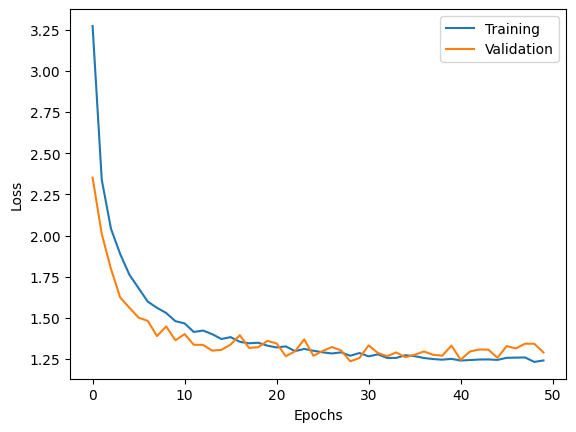

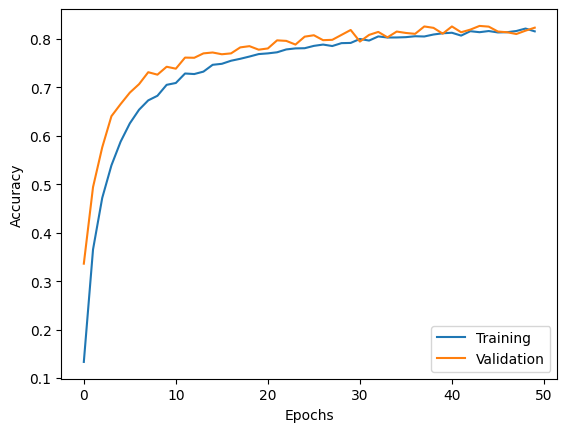

In [40]:
plot_history(hist)